## Import Data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Fedex.csv')

In [4]:
review = data[['Review']]

In [5]:
review

,Review
0,I ordered a very important package that needed...
1,I had ordered a part for my car on Thursday 12...
2,⭐️⭐️⭐️⭐️⭐️⭐️⭐️ I’m giving 7 stars out of 5 sta...
3,I was a FedEx Ground driver. The customers wil...
4,Last month I ordered from a catalog and it was...
...,...
3819,Worst delivery company : Worst delivery compan...
3820,They NEVER deliver on time. :
3821,Ordered coffee pot from walmart : Ordered coff...
3822,Mail order companies stop using FED EX.. Pleas...


## Keyword Extraction

In [12]:
from collections import OrderedDict
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

In [21]:
nlp = en_core_web_sm.load()

In [24]:
class TextRank_KeywordExtraction():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        dict_ = {}
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            dict_[key] = value
            #print(key + ' - ' + str(value))
            if i > number:
                break
        return dict_
        
        
    def analyze(self, text,
                candidate_pos=['NOUN', 'PROPN', 'VERB'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

In [25]:
# an example
text = review['Review'].iloc[0]
text

"I ordered a very important package that needed to be handled with care as it was very expensive almost 2 thousand dollars. The FedEx driver delivered it on a day where the weather was horrible. Not his fault of course. He double bagged my package in to giant plastic bags, tied the ends of the bags and he was not satisfied with just that since he didn't think that would keep it dry since the wind was also blowing very hard. He took my recycle bin that was outside and placed it over the bagged packages and then also grabbed a piece of a cinder block of concrete and placed it on top of the recycle bin. After that he wrote a note and placed the note inside my storm door telling me where my package was and why he did that. He wanted to make sure it didn't get wet, destroyed or stolen and I certainly appreciated the job he did and continues to do."

In [26]:
trke = TextRank_KeywordExtraction()
trke.analyze(text, candidate_pos = ['NOUN', 'PROPN', 'VERB'], window_size=4, lower=False)
trke.get_keywords(10)

{'placed': 2.239681033979248,
 'package': 1.7991386513949013,
 'bags': 1.5673711670274169,
 'bagged': 1.3195026461468427,
 'note': 1.155541403190064,
 'recycle': 1.053139273259809,
 'bin': 1.0464494584449942,
 'ends': 1.045894276094276,
 'needed': 1.0451487373737374,
 'handled': 1.0451487373737374,
 'driver': 1.0,
 'delivered': 1.0}

In [37]:
# cumulate the value for each keyword
keyword_value = {}
trke = TextRank_KeywordExtraction()
for i in range(len(review)):
    dict_ = {}
    text = review['Review'].iloc[i]
    trke.analyze(text, candidate_pos = ['NOUN', 'PROPN', 'VERB'], window_size=4, lower=False)
    dict_ = trke.get_keywords(10)
    for key in dict_.keys():
        if keyword_value.get(key):
            keyword_value[key] = keyword_value[key] + dict_[key]
        else:
            keyword_value[key] = dict_[key]

In [38]:
keyword_value

{'placed': 22.54520651486217,
 'package': 2625.7929486200987,
 'bags': 8.619866897680565,
 'bagged': 1.3195026461468427,
 'note': 48.48246110288752,
 'recycle': 1.053139273259809,
 'bin': 2.180914736222772,
 'ends': 4.045894276094276,
 'needed': 48.96436218657686,
 'handled': 9.003251844658319,
 'driver': -6.808009734004307e+64,
 'delivered': 1035.7644942213408,
 'gentleman': 7.145373406578541,
 'center': 41.66637855758193,
 'thank': 16.440308289062678,
 'finished': 3.1433119020061726,
 'Jacksonville': 4.011663467261905,
 'car': 18.55761668332136,
 'called': 301.15680307815904,
 'sorting': 6.836042881944444,
 'told': nan,
 'truck': 240.6107273388156,
 'FedEx': -2.052013316187654e+249,
 'Cochin': 2.38195099269943,
 'parcel': 161.49181403138317,
 'service': 1.1684698681366042e+77,
 'team': 18.380068917944005,
 'DTDC': 1.3717405893874641,
 'delivery': 1695.4419529694546,
 'assured': 18.398857609241336,
 'stars': 75.36328089740947,
 'ASPARTS': 1.2002379629629627,
 'Arun': 1.181742592592592

In [821]:
sorted_keyword = sorted(keyword_value.items(), key=lambda x: x[1], reverse = True)
sorted_keyword

[('told', nan),
 ('said', 1.1116625138327005e+283),
 ('service', 1.1684698681366042e+77),
 ('learn', 1.0971718031532103e+77),
 ('ETA', 2.930311035090003e+76),
 ('charges', 18.5972580275698),
 ('HORRIBLE', 17.170016371552826),
 ('£', 16.18819816496546),
 ('walmart', 10.15642782952014),
 ('DELIVER', 9.288153488893261),
 ('medication', 9.197811774923158),
 ('collect', 9.140566459317853),
 ('debt', 8.487928938728269),
 ('Stay', 8.122777777777777),
 ('reasons', 7.62592479912764),
 ('AVOID', 7.539828703703703),
 ('technology', 7.432537989448608),
 ('seconds', 6.916429861111111),
 ('Phoenix', 6.716681066761721),
 ('loaded', 6.675599713825085),
 ('self', 6.674884589722846),
 ('Walmart.com', 6.226856944444444),
 ('training', 6.079990647868995),
 ('Jersey', 5.969882137345678),
 ('3rd', 5.9253701879469745),
 ('noted', 5.812945546737213),
 ('HOME', 5.648017063492063),
 ('LIE', 5.548950565306271),
 ('Website', 5.527708333333333),
 ('managers', 5.526781937429854),
 ('SHIPPING', 5.361129330193616),
 

In [831]:
from math import isnan
# functional
clean_keyword_value = {k: keyword_value[k] for k in keyword_value if not isnan(keyword_value[k])}

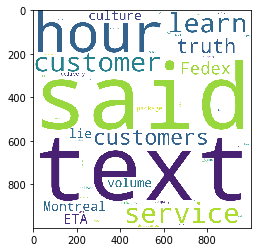

In [834]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(clean_keyword_value)
plt.imshow(wc)

In [835]:
df_keyword = pd.DataFrame(sorted_keyword)

In [836]:
df_keyword

,0,1
0,told,NaN
1,said,1.111663e+283
2,service,1.168470e+77
3,learn,1.097172e+77
4,ETA,2.930311e+76
...,...,...
5499,27.06.19,1.500000e-01
5500,Disgusting,1.500000e-01
5501,useless,1.500000e-01
5502,shock,1.500000e-01


In [840]:
list(df_keyword[0][1:20])

['said',
 'service',
 'learn',
 'ETA',
 'charges',
 'HORRIBLE',
 '£',
 'walmart',
 'DELIVER',
 'medication',
 'collect',
 'debt',
 'Stay',
 'reasons',
 'AVOID',
 'technology',
 'seconds',
 'Phoenix',
 'loaded']

## Intent Classification

In [380]:
# give intent to the first 100 reviews manually, then utilize it as the trainset
intent

['satisfy.driver',
 'satisfy.driver',
 'satisfy.service',
 'dissatisfy.wait',
 'dissatisfy.change_carrier',
 'dissatisfy.wrong_address',
 'dissatisfy.wrong_address',
 'dissatisfy.wrong_address',
 'dissatisfy.driver',
 'dissatisfy.wrong_delivered_info',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.driver',
 'dissatisfy.driver',
 'dissatisfy.wait',
 'dissatisfy.package_damage',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.package_damage',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.package_missing',
 'dissatisfy.driver',
 'dissatisfy.shipment',
 'dissatisfy.package_missing',
 'dissatisfy.wait',
 'dissatisfy.service',
 'dissatisfy.wait',
 'dissatisfy.package_missing',
 'dissatisfy.driver',
 'dissatisfy.wait',
 'dissatisfy.package_missing',
 'dissatisfy.driver',
 'dissatisfy.wait',
 'dissatisfy.wait',
 'dissatisfy.package_missing',
 'dissatisfy.dr

In [382]:
# create the database
review_intent = pd.DataFrame()
review_intent['Review'] = review['Review'][:100]
review_intent['Intent'] = intent

In [383]:
review_intent

,Review,Intent
0,I ordered a very important package that needed...,satisfy.driver
1,I had ordered a part for my car on Thursday 12...,satisfy.driver
2,⭐️⭐️⭐️⭐️⭐️⭐️⭐️ I’m giving 7 stars out of 5 sta...,satisfy.service
3,I was a FedEx Ground driver. The customers wil...,dissatisfy.wait
4,Last month I ordered from a catalog and it was...,dissatisfy.change_carrier
...,...,...
95,They always deliver packages to front door. Ne...,satisfy.driver
96,We get 40-50 boxes of very heavy tax manuals e...,satisfy.driver
97,I have used this company Express and ground se...,satisfy.service
98,I love FedEx because they always deliver my pa...,satisfy.on_time


In [384]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [386]:
sentences = list(review_intent['Review'])
sentences[:3]

["I ordered a very important package that needed to be handled with care as it was very expensive almost 2 thousand dollars. The FedEx driver delivered it on a day where the weather was horrible. Not his fault of course. He double bagged my package in to giant plastic bags, tied the ends of the bags and he was not satisfied with just that since he didn't think that would keep it dry since the wind was also blowing very hard. He took my recycle bin that was outside and placed it over the bagged packages and then also grabbed a piece of a cinder block of concrete and placed it on top of the recycle bin. After that he wrote a note and placed the note inside my storm door telling me where my package was and why he did that. He wanted to make sure it didn't get wet, destroyed or stolen and I certainly appreciated the job he did and continues to do.",
 "I had ordered a part for my car on Thursday 12/5. The part was in Jacksonville by 7:00 pm. on 12/6. I knew the part couldn't make to that da

In [387]:
#define stemmer
stemmer = LancasterStemmer()
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    return words

In [388]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])

100
[['i', 'ordered', 'a', 'very', 'important', 'package', 'that', 'needed', 'to', 'be', 'handled', 'with', 'care', 'as', 'it', 'was', 'very', 'expensive', 'almost', '2', 'thousand', 'dollars', 'the', 'fedex', 'driver', 'delivered', 'it', 'on', 'a', 'day', 'where', 'the', 'weather', 'was', 'horrible', 'not', 'his', 'fault', 'of', 'course', 'he', 'double', 'bagged', 'my', 'package', 'in', 'to', 'giant', 'plastic', 'bags', 'tied', 'the', 'ends', 'of', 'the', 'bags', 'and', 'he', 'was', 'not', 'satisfied', 'with', 'just', 'that', 'since', 'he', 'didn', 't', 'think', 'that', 'would', 'keep', 'it', 'dry', 'since', 'the', 'wind', 'was', 'also', 'blowing', 'very', 'hard', 'he', 'took', 'my', 'recycle', 'bin', 'that', 'was', 'outside', 'and', 'placed', 'it', 'over', 'the', 'bagged', 'packages', 'and', 'then', 'also', 'grabbed', 'a', 'piece', 'of', 'a', 'cinder', 'block', 'of', 'concrete', 'and', 'placed', 'it', 'on', 'top', 'of', 'the', 'recycle', 'bin', 'after', 'that', 'he', 'wrote', 'a', 'n

In [389]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token
def max_length(words):
    return(len(max(words, key = len)))

In [390]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 2108 and Maximum length = 932


In [392]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [393]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
padded_doc = padding_doc(encoded_doc, max_length)

In [394]:
padded_doc[:2]

array([[ 2, 92,  5, ...,  0,  0,  0],
       [ 2, 35, 92, ...,  0,  0,  0]], dtype=int32)

In [395]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (100, 932)


In [400]:
unique_intent = list(set(review_intent['Intent']))
unique_intent[:3]

['dissatisfy.driver', 'satisfy.service', 'dissatisfy.package_damage']

In [401]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')
output_tokenizer.word_index

{'dissatisfy.driver': 1,
 'satisfy.service': 2,
 'dissatisfy.package_damage': 3,
 'dissatisfy.change_carrier': 4,
 'dissatisfy.wrong_address': 5,
 'dissatisfy.custom': 6,
 'satisfy.on_time': 7,
 'dissatisfy.company': 8,
 'satisfy.driver': 9,
 'dissatisfy.shipment': 10,
 'dissatisfy.wrong_delivered_info': 11,
 'dissatisfy.wait': 12,
 'dissatisfy.package_missing': 13,
 'dissatisfy.service': 14}

In [402]:
intent = review_intent['Intent']

In [403]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [405]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [406]:
encoded_output.shape

(100, 1)

In [407]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [408]:
output_one_hot = one_hot(encoded_output)

In [409]:
output_one_hot.shape

(100, 14)

In [410]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (80, 932) and train_Y = (80, 14)
Shape of val_X = (20, 932) and val_Y = (20, 14)


In [617]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(14, activation = "softmax"))

    return model

In [618]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 932, 128)          269824    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_15 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 14)                462       
Total params: 541,678
Trainable params: 271,854
Non-trainable params: 269,824
_________________________________________________________________


In [426]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 4s 46ms/step - loss: 0.1712 - accuracy: 0.9375 - val_loss: 6.1250 - val_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 6.12497, saving model to model.h5
Epoch 2/100
80/80 [==============================] - 4s 50ms/step - loss: 0.1329 - accuracy: 0.9625 - val_loss: 6.0957 - val_accuracy: 0.3000

Epoch 00002: val_loss improved from 6.12497 to 6.09575, saving model to model.h5
Epoch 3/100
80/80 [==============================] - 4s 50ms/step - loss: 0.1702 - accuracy: 0.9375 - val_loss: 6.4728 - val_accuracy: 0.3500

Epoch 00003: val_loss did not improve from 6.09575
Epoch 4/100
80/80 [==============================] - 4s 49ms/step - loss: 0.1607 - accuracy: 0.9625 - val_loss: 6.4540 - val_accuracy: 0.3000

Epoch 00004: val_loss did not improve from 6.09575
Epoch 5/100
80/80 [==============================] - 4s 47ms/step - loss: 0.3868 - accuracy: 0.8500 - val_loss: 6.5425 - val

80/80 [==============================] - 6s 75ms/step - loss: 0.1540 - accuracy: 0.9625 - val_loss: 7.5207 - val_accuracy: 0.4000

Epoch 00042: val_loss did not improve from 5.28899
Epoch 43/100
80/80 [==============================] - 7s 93ms/step - loss: 0.1124 - accuracy: 0.9875 - val_loss: 7.5859 - val_accuracy: 0.4500

Epoch 00043: val_loss did not improve from 5.28899
Epoch 44/100
80/80 [==============================] - 9s 113ms/step - loss: 0.0838 - accuracy: 0.9875 - val_loss: 7.5147 - val_accuracy: 0.4500

Epoch 00044: val_loss did not improve from 5.28899
Epoch 45/100
80/80 [==============================] - 6s 73ms/step - loss: 0.2018 - accuracy: 0.9125 - val_loss: 7.3991 - val_accuracy: 0.4500

Epoch 00045: val_loss did not improve from 5.28899
Epoch 46/100
80/80 [==============================] - 6s 81ms/step - loss: 0.1576 - accuracy: 0.9500 - val_loss: 7.3900 - val_accuracy: 0.4000

Epoch 00046: val_loss did not improve from 5.28899
Epoch 47/100
80/80 [=================

80/80 [==============================] - 6s 72ms/step - loss: 0.2152 - accuracy: 0.9125 - val_loss: 5.7135 - val_accuracy: 0.4500

Epoch 00084: val_loss did not improve from 4.44738
Epoch 85/100
80/80 [==============================] - 5s 64ms/step - loss: 0.1666 - accuracy: 0.9375 - val_loss: 5.8058 - val_accuracy: 0.4500

Epoch 00085: val_loss did not improve from 4.44738
Epoch 86/100
80/80 [==============================] - 5s 59ms/step - loss: 0.1717 - accuracy: 0.9375 - val_loss: 5.9041 - val_accuracy: 0.4500

Epoch 00086: val_loss did not improve from 4.44738
Epoch 87/100
80/80 [==============================] - 5s 60ms/step - loss: 0.1129 - accuracy: 0.9750 - val_loss: 6.1671 - val_accuracy: 0.4500

Epoch 00087: val_loss did not improve from 4.44738
Epoch 88/100
80/80 [==============================] - 5s 60ms/step - loss: 0.2264 - accuracy: 0.9125 - val_loss: 6.2595 - val_accuracy: 0.4000

Epoch 00088: val_loss did not improve from 4.44738
Epoch 89/100
80/80 [==================

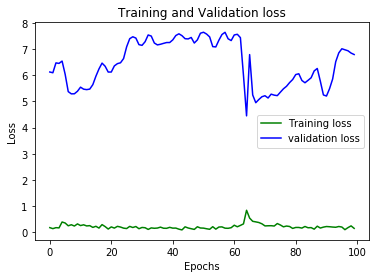

In [434]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

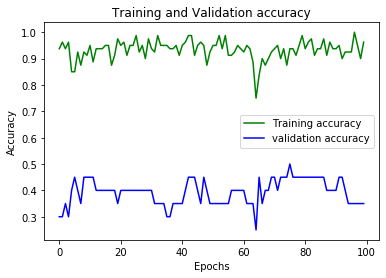

In [435]:
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# have overfitting issues: data size is too small

In [440]:
model = load_model("model.h5")

In [453]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))

    test_ls = np.array(test_ls).reshape(1, len(test_ls))

    x = padding_doc(test_ls, max_length)

    pred = model.predict_proba(x)

    return pred

In [454]:
def get_final_output(pred, classes):
    predictions = pred[0]
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    return classes[0]

In [455]:
pred_text = list(review['Review'][100:])

In [456]:
pred_text

["Many times my packages are left outside in the elements. I have signs up where to put them but it doesn't seem to matter. Their deleivery times are pretty good and the drivers when I see them are usually pretty nice. Overall their service is good. Just wish they would respect my signs and put items inside the drop door.",
 "I've only used FedEx a handful of times but they are definitely my go to shipper. I'm in the process of starting an online business and FedEx is it. Every time I have used them they are always on time and their drivers are top notch.",
 'Usually Professional and prompt. Work very hard and do a yet good job. I’ve never had a problem with any delivery and highly recommend them. Can’t miss their truck and I’m always excited to see it coming.',
 'I’ve been doing business with Fed Ex for over thirty years. I have mailed packages that number in the thousands all over the globe and have never had thing one go wrong. Not one missing package, not one item ever damaged in t

In [457]:
indent_list = []
for text in pred_text:
    pred = predictions(text)
    indent_list.append(get_final_output(pred, unique_intent))

In [458]:
indent_list

['dissatisfy.wrong_address',
 'dissatisfy.wrong_address',
 'satisfy.on_time',
 'dissatisfy.driver',
 'satisfy.driver',
 'satisfy.on_time',
 'satisfy.on_time',
 'satisfy.on_time',
 'satisfy.driver',
 'satisfy.driver',
 'dissatisfy.wrong_address',
 'dissatisfy.wrong_delivered_info',
 'dissatisfy.wrong_address',
 'satisfy.on_time',
 'satisfy.on_time',
 'satisfy.on_time',
 'dissatisfy.wrong_delivered_info',
 'satisfy.on_time',
 'dissatisfy.wrong_address',
 'satisfy.on_time',
 'dissatisfy.wrong_address',
 'dissatisfy.wrong_address',
 'dissatisfy.service',
 'satisfy.driver',
 'satisfy.driver',
 'dissatisfy.wrong_address',
 'dissatisfy.package_damage',
 'dissatisfy.company',
 'satisfy.on_time',
 'dissatisfy.wrong_delivered_info',
 'dissatisfy.package_damage',
 'dissatisfy.package_damage',
 'satisfy.on_time',
 'dissatisfy.wrong_delivered_info',
 'satisfy.on_time',
 'satisfy.driver',
 'dissatisfy.service',
 'satisfy.on_time',
 'satisfy.driver',
 'satisfy.on_time',
 'dissatisfy.service',
 'satis

In [459]:
list_ = list(review_intent['Intent']) + indent_list
review['Indent'] = list_

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [460]:
review

,Review,Indent
0,I ordered a very important package that needed...,satisfy.driver
1,I had ordered a part for my car on Thursday 12...,satisfy.driver
2,⭐️⭐️⭐️⭐️⭐️⭐️⭐️ I’m giving 7 stars out of 5 sta...,satisfy.service
3,I was a FedEx Ground driver. The customers wil...,dissatisfy.wait
4,Last month I ordered from a catalog and it was...,dissatisfy.change_carrier
...,...,...
3819,Worst delivery company : Worst delivery compan...,dissatisfy.wait
3820,They NEVER deliver on time. :,satisfy.driver
3821,Ordered coffee pot from walmart : Ordered coff...,dissatisfy.driver
3822,Mail order companies stop using FED EX.. Pleas...,dissatisfy.package_damage


In [847]:
new_list = [(i.split('.')[0],i.split('.')[1]) for i in list_]
review['Indent_0'] = list(zip(*new_list))[0]
review['Indent_1'] = list(zip(*new_list))[1]
review['count'] = 1

In [848]:
review.head()

,Review,Indent,Indent_0,Indent_1,count
0,I ordered a very important package that needed...,satisfy.driver,satisfy,driver,1
1,I had ordered a part for my car on Thursday 12...,satisfy.driver,satisfy,driver,1
2,⭐️⭐️⭐️⭐️⭐️⭐️⭐️ I’m giving 7 stars out of 5 sta...,satisfy.service,satisfy,service,1
3,I was a FedEx Ground driver. The customers wil...,dissatisfy.wait,dissatisfy,wait,1
4,Last month I ordered from a catalog and it was...,dissatisfy.change_carrier,dissatisfy,change_carrier,1


In [850]:
import plotly.express as px
fig = px.sunburst(review, path=['Indent_0', 'Indent_1'], values='count')
fig.show()

## Opinion Mining

In [470]:
import nltk
import re
import sys
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet

In [471]:
# Pre-processing
def preProcessing(text):
    cachedStopWords = nltk.corpus.stopwords.words('english')
    result = (' '.join([word for word in text.split(' ') if word.lower() not in cachedStopWords]))
    return result

In [472]:
def tokenizeReviews(result):
    tokenizedReviews = {}
    tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
    uniqueId = 1
    cachedStopWords = nltk.corpus.stopwords.words("english")
    for sentence in tokenizer.tokenize(result):
        tokenizedReviews[uniqueId] = sentence
        uniqueId += 1
    return tokenizedReviews

In [473]:
def posTagging(tokenizedReviews):
    inputTupples = tokenizedReviews
    outputPost = {}
    for key, value in inputTupples.items():
        outputPost[key] = nltk.pos_tag(nltk.word_tokenize(value))
    return outputPost

In [474]:
def aspectExtraction(outputPost):
    inputTupples = outputPost
    prevWord = ''
    prevTag = ''
    currWord = ''
    aspectList = []
    outputDict = {}
    #Extracting aspects
    for key, value in inputTupples.items():
        for word, tag in value:
            if (tag=='NN' or tag=='NNP'):
                if (prevTag == 'NN' or prevTag=='NNP'):
                    if (prevWord == word):
                        currWord = word     # music music
                    else:
                        currWord = prevWord + ' ' + word
                else:
                    aspectList.append(prevWord.upper())
                    currWord = word

            prevWord = currWord
            prevTag = tag


    #Eliminating aspect which has 1 or less count
    for aspect in aspectList:
        if(aspectList.count(aspect) > 1):
            if(outputDict.keys() != aspect):
                outputDict[aspect] = aspectList.count(aspect)

    outputAspect = sorted(outputDict.items(), key=lambda x: x[1], reverse=True)
    return outputAspect

In [509]:
def identifyOpinionWords(outputPost, outputAspect):
    outputAspectOpinionTuples={}
    orientationCache={}
    negativeWordSet = {"don't","never", "nothing", "nowhere", "noone", "none", "not",
                  "hasn't","hadn't","can't","couldn't","shouldn't","won't",
                  "wouldn't","don't","doesn't","didn't","isn't","aren't","ain't"}
    aspect_dict = dict()
    for aspect,no in outputAspect:
        aspectTokens= word_tokenize(aspect)
        count=0
        for key,value in outputPost.items():
            condition=True
            isNegativeSen=False
            for subWord in aspectTokens:
                if(subWord in str(value).upper()):
                    condition = condition and True
                else:
                    condition = condition and False
            if(condition):
                for negWord in negativeWordSet:
                    if(not isNegativeSen):#once senetence is negative no need to check this condition again and again
                        if negWord.upper() in str(value).upper():
                            isNegativeSen=isNegativeSen and True
                outputAspectOpinionTuples.setdefault(aspect,[0,0,0])
                for word,tag in value:
                    if (tag=='JJ' or tag=='JJR' or tag=='JJS'or tag== 'RB' or tag== 'RBR'or tag== 'RBS'):
                        count+=1
                        if(word not in orientationCache):
                            orien=orientation(word)
                            orientationCache[word]=orien
                        else:
                            orien=orientationCache[word]
                        if(isNegativeSen and orien is not None):
                            orien= not orien
                        if(orien==True):
                            outputAspectOpinionTuples[aspect][0]+=1
                        elif(orien==False):
                            outputAspectOpinionTuples[aspect][1]+=1
                        elif(orien is None):
                            outputAspectOpinionTuples[aspect][2]+=1
        if(count>0):
            outputAspectOpinionTuples[aspect][0]=round((outputAspectOpinionTuples[aspect][0]/count)*100,2)
            outputAspectOpinionTuples[aspect][1]=round((outputAspectOpinionTuples[aspect][1]/count)*100,2)
            outputAspectOpinionTuples[aspect][2]=round((outputAspectOpinionTuples[aspect][2]/count)*100,2)
            aspect_dict[aspect] = {'Positive':outputAspectOpinionTuples[aspect][0],'Negative':outputAspectOpinionTuples[aspect][1]}
    return aspect_dict

In [483]:
def orientation(inputWord): 
    wordSynset=wordnet.synsets(inputWord)
    if(len(wordSynset) != 0):
        word=wordSynset[0].name()
        orientation=sentiwordnet.senti_synset(word)
        if(orientation.pos_score()>orientation.neg_score()):
            return True
        elif(orientation.pos_score()<orientation.neg_score()):
            return False

In [506]:
x = ' '.join(list(review['Review']))

In [507]:
cleaned_x = preProcessing(x)
token_x = tokenizeReviews(cleaned_x)
pos_tag_x = posTagging(token_x)
aspect_x = aspectExtraction(pos_tag_x)
identify_x = identifyOpinionWords(pos_tag_x, aspect_x)

In [511]:
identify_x

{'FEDEX': {'Positive': 15.6, 'Negative': 20.14},
 'PACKAGE': {'Positive': 13.53, 'Negative': 16.25},
 'DELIVERY': {'Positive': 14.79, 'Negative': 17.14},
 'TIME': {'Positive': 14.77, 'Negative': 16.09},
 'DAY': {'Positive': 12.18, 'Negative': 13.66},
 'COMPANY': {'Positive': 16.02, 'Negative': 26.87},
 'CUSTOMER SERVICE': {'Positive': 15.63, 'Negative': 24.6},
 'SERVICE': {'Positive': 17.05, 'Negative': 26.07},
 'DOOR': {'Positive': 11.76, 'Negative': 13.24},
 'DRIVER': {'Positive': 15.1, 'Negative': 15.78},
 'TODAY': {'Positive': 14.57, 'Negative': 15.62},
 'HOME': {'Positive': 12.78, 'Negative': 15.42},
 'ADDRESS': {'Positive': 14.3, 'Negative': 22.44},
 'BUSINESS': {'Positive': 17.88, 'Negative': 19.83},
 'HOUSE': {'Positive': 14.58, 'Negative': 15.27},
 'WEEK': {'Positive': 12.57, 'Negative': 13.76},
 'TRUCK': {'Positive': 11.25, 'Negative': 14.36},
 'WAY': {'Positive': 13.28, 'Negative': 12.69},
 'NOTHING': {'Positive': 15.35, 'Negative': 16.62},
 'UPS': {'Positive': 17.71, 'Negat

In [515]:
identify_df = pd.DataFrame(identify_x).T

In [853]:
identify_df['Difference'] = identify_df['Positive'] - identify_df['Negative']
identify_df['Sum'] = identify_df['Positive'] + identify_df['Negative']

In [859]:
identify_df.head(20)

,Positive,Negative,Difference,Sum
FEDEX,15.60,20.14,-4.54,35.74
PACKAGE,13.53,16.25,-2.72,29.78
DELIVERY,14.79,17.14,-2.35,31.93
TIME,14.77,16.09,-1.32,30.86
DAY,12.18,13.66,-1.48,25.84
COMPANY,16.02,26.87,-10.85,42.89
CUSTOMER SERVICE,15.63,24.60,-8.97,40.23
SERVICE,17.05,26.07,-9.02,43.12
DOOR,11.76,13.24,-1.48,25.00
DRIVER,15.10,15.78,-0.68,30.88


In [876]:
list(identify_df.index[:10])

['FEDEX',
 'PACKAGE',
 'DELIVERY',
 'TIME',
 'DAY',
 'COMPANY',
 'CUSTOMER SERVICE',
 'SERVICE',
 'DOOR',
 'DRIVER']

In [877]:
import plotly.graph_objects as go
words=list(identify_df.index[:10])

fig = go.Figure(data=[
    go.Bar(name='positive', x=words, y=identify_df.Positive[:10]),
    go.Bar(name='negative', x=words, y=identify_df.Negative[:10])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

## Bert

In [811]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [812]:
review_intent_0

,Review,Intent,label
0,I ordered a very important package that needed...,satisfy.driver,9
1,I had ordered a part for my car on Thursday 12...,satisfy.driver,9
2,⭐️⭐️⭐️⭐️⭐️⭐️⭐️ I’m giving 7 stars out of 5 sta...,satisfy.service,2
3,I was a FedEx Ground driver. The customers wil...,dissatisfy.wait,12
4,Last month I ordered from a catalog and it was...,dissatisfy.change_carrier,4
...,...,...,...
95,They always deliver packages to front door. Ne...,satisfy.driver,9
96,We get 40-50 boxes of very heavy tax manuals e...,satisfy.driver,9
97,I have used this company Express and ground se...,satisfy.service,2
98,I love FedEx because they always deliver my pa...,satisfy.on_time,7


In [813]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [583]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory

In [814]:
# tokenization
tokenized = review_intent_0['Review'].apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))

In [815]:
tokenized

0     [101, 1045, 3641, 1037, 2200, 2590, 7427, 2008...
1     [101, 1045, 2018, 3641, 1037, 2112, 2005, 2026...
2     [101, 100, 1045, 1521, 1049, 3228, 1021, 3340,...
3     [101, 1045, 2001, 1037, 7349, 10288, 2598, 406...
4     [101, 2197, 3204, 1045, 3641, 2013, 1037, 1210...
                            ...                        
95    [101, 2027, 2467, 8116, 14555, 2000, 2392, 234...
96    [101, 2057, 2131, 2871, 1011, 2753, 8378, 1997...
97    [101, 1045, 2031, 2109, 2023, 2194, 4671, 1998...
98    [101, 1045, 2293, 7349, 10288, 2138, 2027, 246...
99    [101, 2477, 2024, 5091, 2108, 3714, 2030, 1613...
Name: Review, Length: 100, dtype: object

In [586]:
# padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [809]:
padded

array([[ 101, 1045, 3641, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101,  100, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2031, ...,    0,    0,    0],
       [ 101, 1045, 2293, ...,    0,    0,    0],
       [ 101, 2477, 2024, ...,    0,    0,    0]])

In [599]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))
features = last_hidden_states[0][:,0,:].numpy()
labels = one_hot(np.array(review_intent_0['label']).reshape(len(review_intent_0['label']), 1))

In [601]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [810]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(padded, labels, shuffle = True, test_size = 0.2)
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (80, 136) and train_Y = (80, 14)
Shape of val_X = (20, 136) and val_Y = (20, 14)
